In [30]:
import h5py
import numpy as np
import pickle
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

import dynesty
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
chaintag = 'wp_xi_upf_mcf_xi2_c1h12_all'
chain_params_fn = f'../chains/param_files/chain_params_{chaintag}.h5'

In [3]:
f = h5py.File(chain_params_fn, 'r+')

cosmo = f.attrs['cosmo']
hod = f.attrs['hod']
    
statistics = f.attrs['statistics']
emu_names = f.attrs['emu_names']
scalings = f.attrs['scalings']

param_names_vary = f.attrs['param_names_vary']
chain_results_fn = f.attrs['chain_results_fn']

truths = f.attrs['true_values']

f.close()

In [4]:
# get observed values
n_stats = len(statistics)
n_bins = 9
ys_observed = np.empty((n_stats, n_bins))
for i, statistic in enumerate(statistics):
    testing_dir = f'../../clust/results_aemulus_test_mean/results_{statistic}/'
    _, y_obs = np.loadtxt(f'{testing_dir}/{statistic}_cosmo_{cosmo}_HOD_{hod}_mean.dat',
                            delimiter=',', unpack=True)
    ys_observed[i,:] = y_obs

# rebuild emus
emus = [None]*n_stats
for i, statistic in enumerate(statistics):
    Emu = utils.get_emu(emu_names[i])

    train_tag = f'_{emu_names[i]}_{scalings[i]}'
    model_fn = f'../models/model_{statistic}{train_tag}' #emu will add proper file ending
    scaler_x_fn = f'../models/scaler_x_{statistic}{train_tag}.joblib'
    scaler_y_fn = f'../models/scaler_y_{statistic}{train_tag}.joblib'
    err_fn = f"../../clust/covariances/error_aemulus_{statistic}_hod3_test0.dat"

    emu = Emu(statistic, scalings[i], model_fn, scaler_x_fn, scaler_y_fn, err_fn,
              predict_mode=True)
    emu.load_model()
    emus[i] = emu
    print(f"Emulator for {statistic} built with train_tag {train_tag}")

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for wp built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for xi built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for upf built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for mcf built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for xi2 built with train_tag _George_xrsqmean


In [18]:
def get_lowest_likelihood(samples, logl):
    print(len(logl))
    print(np.argmax(logl)) #
    print(np.max(logl))
    params_lowlogl = samples[np.argmax(logl)] #max because logl's are negative
    print(params_lowlogl)
    return params_lowlogl

In [19]:
chain_results_fn = f'../chains/results/results_{chaintag}.pkl'
with open(chain_results_fn, 'rb') as pf:
    res = pickle.load(pf)
    samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
    logl = res.logl
    samples_equal = dyfunc.resample_equal(samples, weights)
    params_lowlogl = get_lowest_likelihood(samples, logl)

35228
35227
-3.7349395345706955
[ 0.30374611  0.05256472  0.72681986  0.66471252  0.98970826  3.23582564
 -0.86982293 14.0994937   0.57748461 11.78951329  0.26292378  0.39407203
  2.00200288  1.88708483  0.76677993 -0.23178316  1.93645605  0.52365974]


In [20]:
n_bins = 9
emulated_lowlogl_arr = np.empty((n_stats, n_bins))
emulated_true_arr = np.empty((n_stats, n_bins))
for i, statistic in enumerate(statistics):
    emulated_lowlogl_arr[i,:] = emus[i].predict(params_lowlogl)
    emulated_true_arr[i,:] = emus[i].predict(truths)

Should this be a figure w/ 5 subplots?

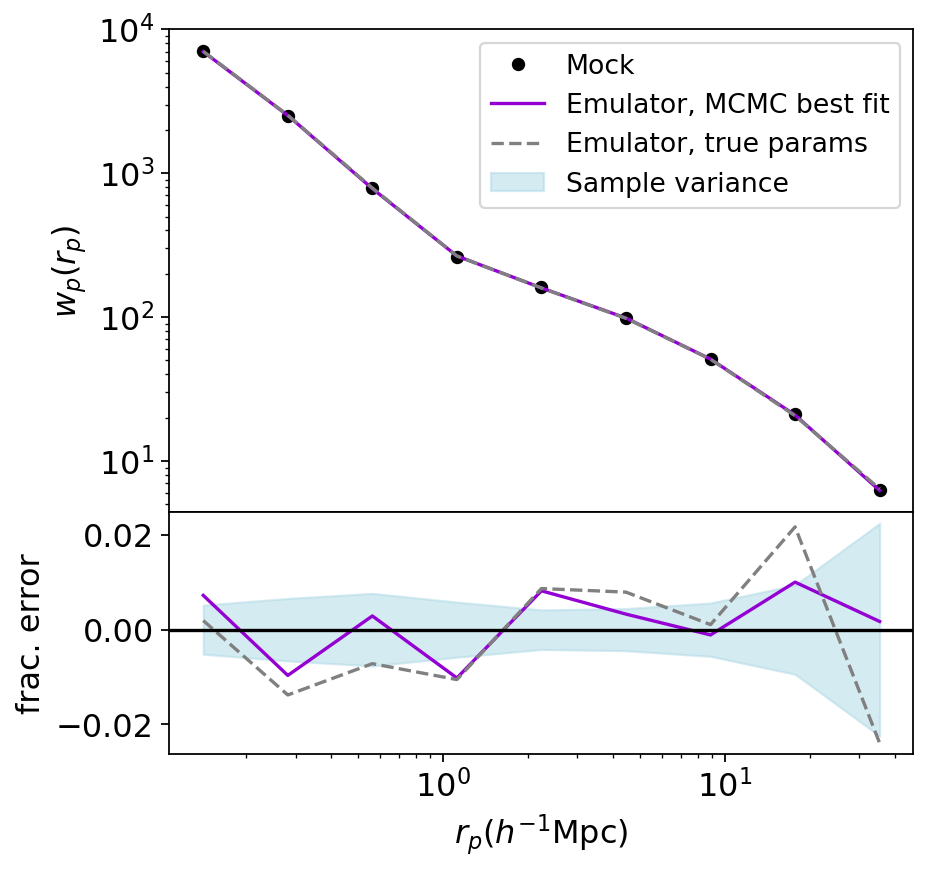

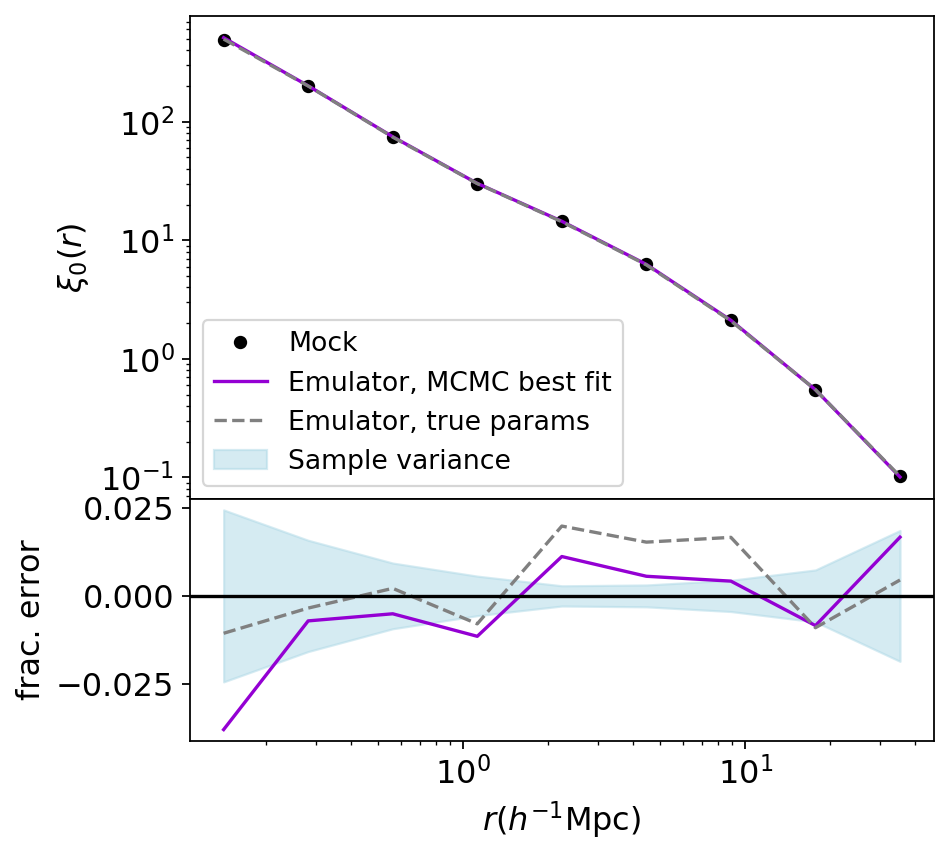

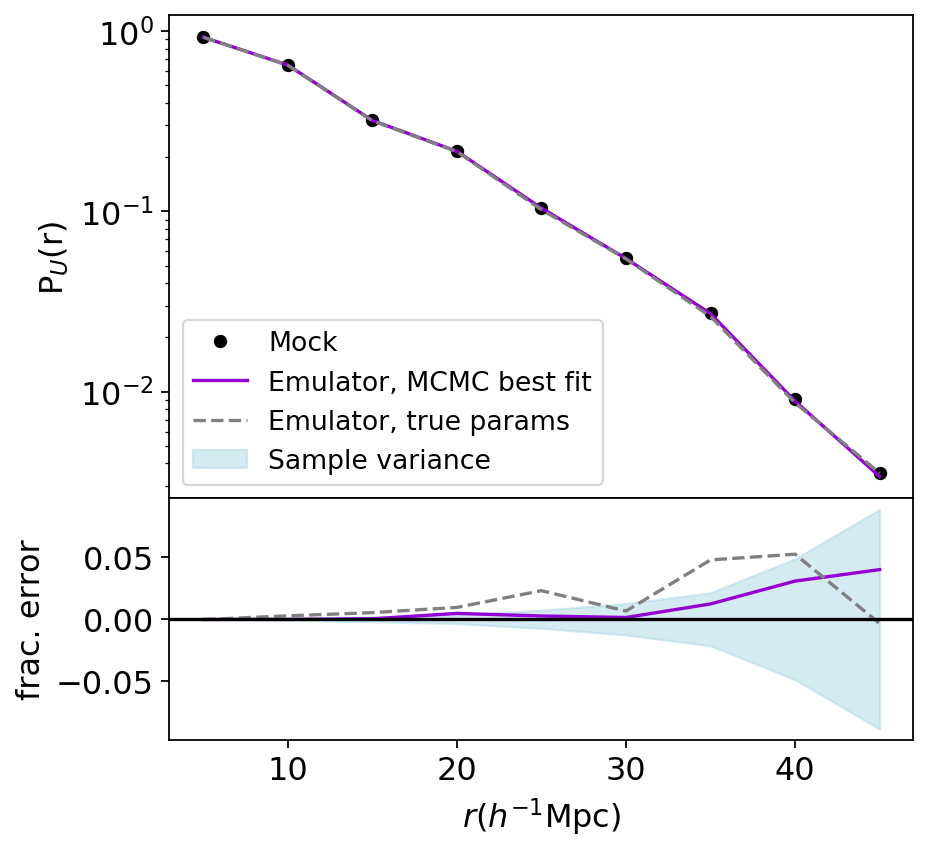

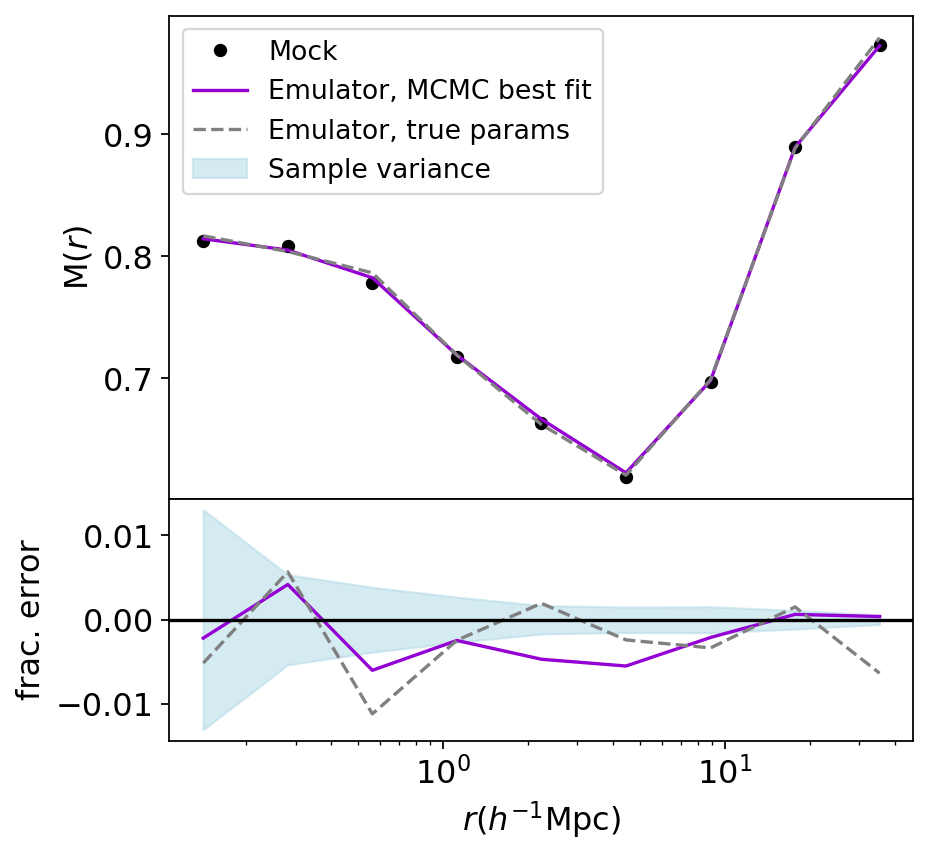

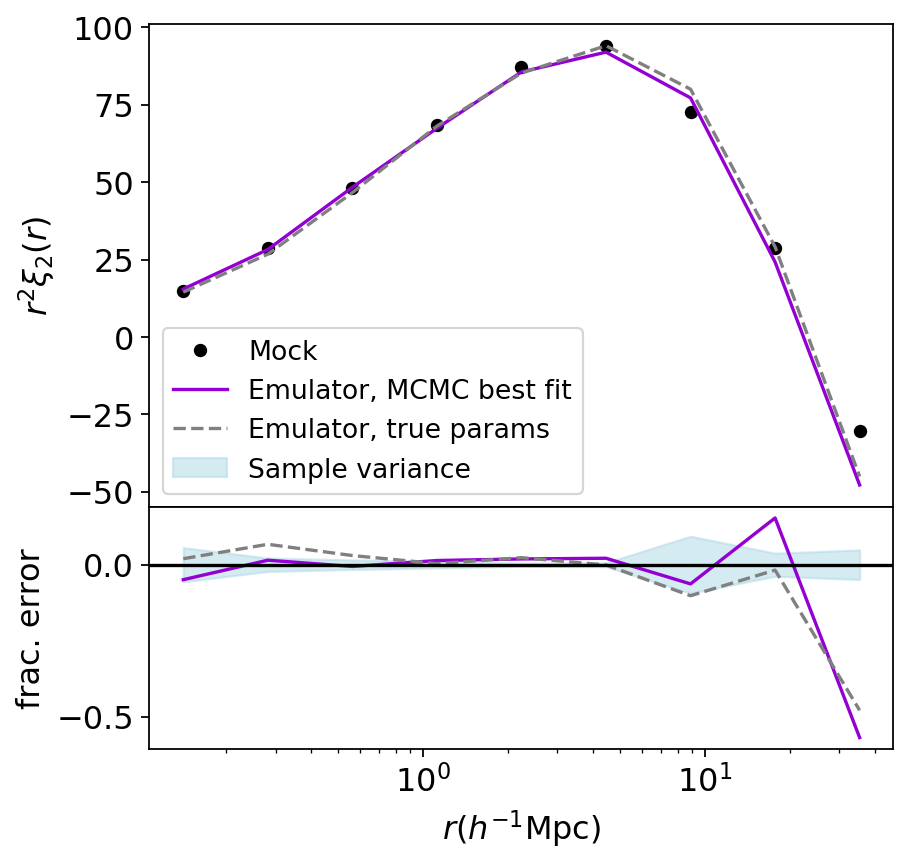

In [41]:
for i, statistic in enumerate(statistics):
    # make error subplot!
    fig, axarr = plt.subplots(2,1,figsize=(6,6),gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=0)

    m = 1
    ylabel = stat_labels[statistic]
    if statistic == 'xi2':
        m = r_dict[statistic]**2
        ylabel = r'$r^2$' + ylabel
    
    # main plot
    axarr[0].plot(r_dict[statistic], m*ys_observed[i], marker='.', ls='None', color='k', markersize=10, label='Mock')
    axarr[0].plot(r_dict[statistic], m*emulated_lowlogl_arr[i], ls='-', color='darkviolet', label='Emulator, MCMC best fit')
    axarr[0].plot(r_dict[statistic], m*emulated_true_arr[i], ls='--', color='grey', label='Emulator, true params')

    # residual plot 
    err_lowlogl = (ys_observed[i] - emulated_lowlogl_arr[i])/ys_observed[i]
    axarr[1].plot(r_dict[statistic], err_lowlogl, ls='-', color='darkviolet')
    err_true = (ys_observed[i] - emulated_true_arr[i])/ys_observed[i]
    axarr[1].plot(r_dict[statistic], err_true, ls='--', color='grey')
    axarr[1].axhline(0.0, color='k')
    
    err_fn = f"../../clust/covariances/error_aemulus_{statistic}_hod3_test0.dat"
    sample_var = np.loadtxt(err_fn)
    sample_var /= np.sqrt(5)
    axarr[1].fill_between(r_dict[statistic], -sample_var, sample_var, color='lightblue', alpha=0.5)
    
    # logistics
    axarr[0].set_xscale(scale_dict[statistic][0])
    axarr[0].set_yscale(scale_dict[statistic][1])
    
    axarr[0].set_ylabel(ylabel)
    handles, labels = axarr[0].get_legend_handles_labels()
    sample_var_patch = mpatches.Patch(color='lightblue', alpha=0.5, label='Sample variance')
    handles.append(sample_var_patch) 
    axarr[0].legend(handles=handles, fontsize=12)
    
    axarr[1].set_xscale(scale_dict[statistic][0])
    axarr[1].set_xlabel(r_labels[statistic])
    axarr[1].set_ylabel('frac. error')

In [39]:
# not mean - best fit! 
# add sample variance - test set dev. from mena

In [40]:
# run one test w diff cov - show contour plot. diagonal cov, gaussian smoothing

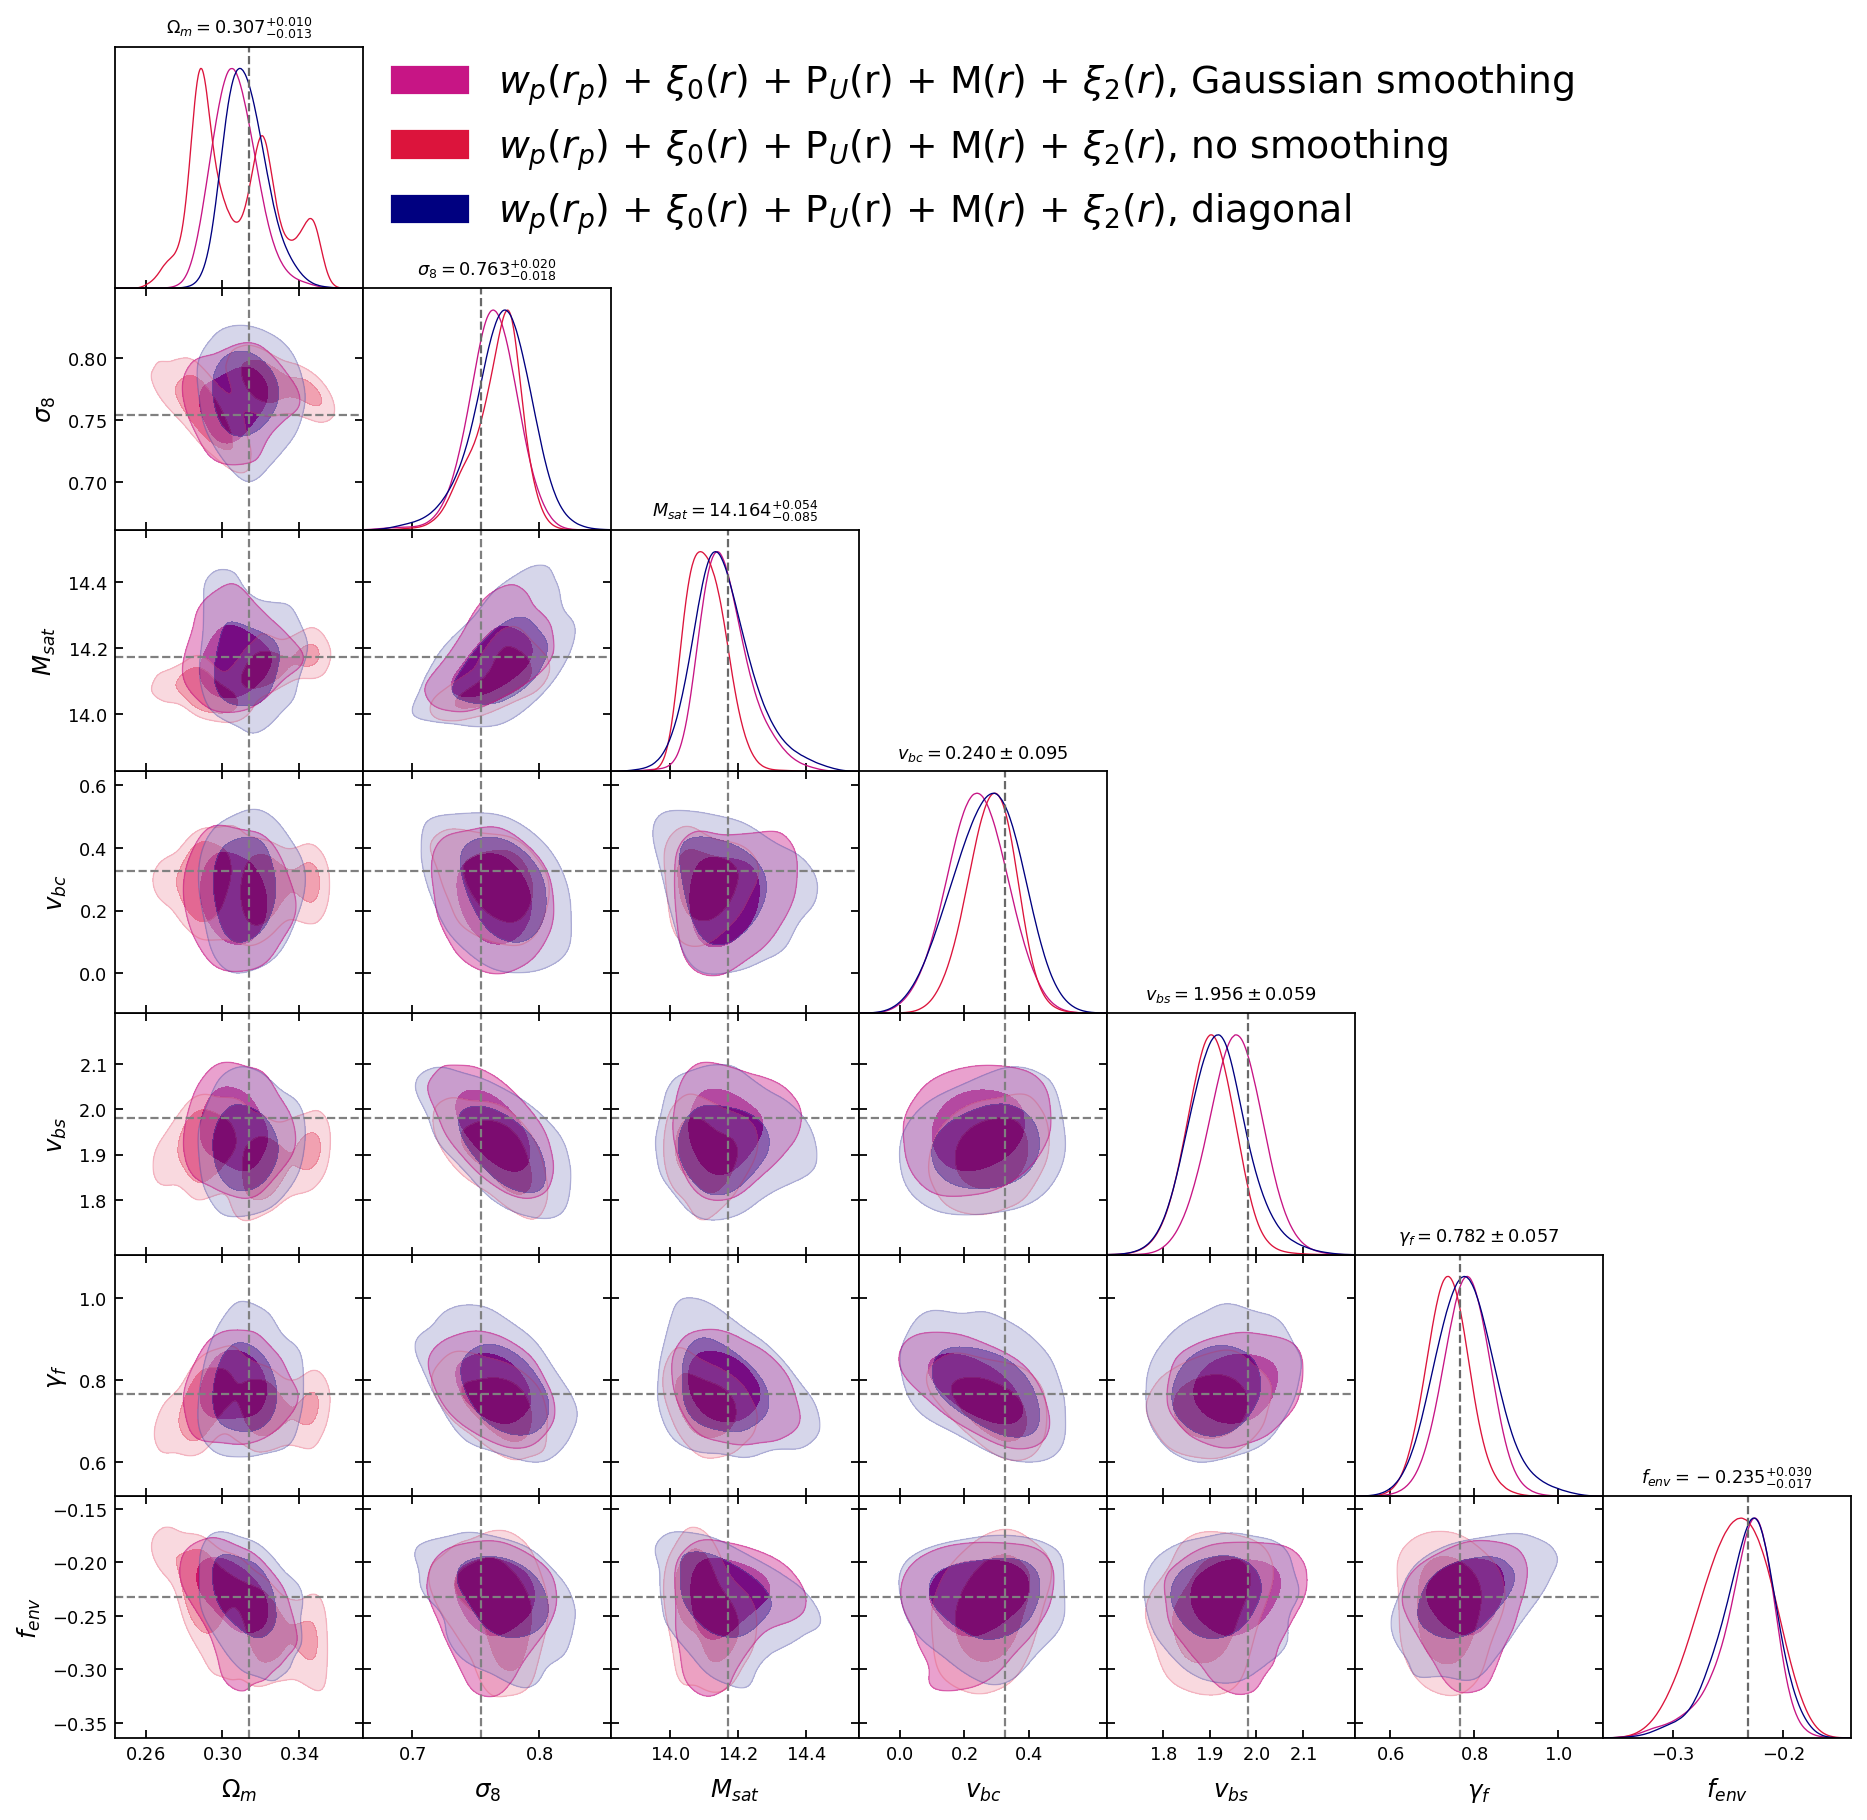

In [37]:
chaintags = [
             'wp_xi_upf_mcf_xi2_c1h12_all',
             'wp_xi_upf_mcf_xi2_c1h12_all_covorig',
             'wp_xi_upf_mcf_xi2_c1h12_all_covdiag',
            ]
legend_labels = [
                 make_label(['wp', 'xi', 'upf', 'mcf', 'xi2']) + ', Gaussian smoothing',
                 make_label(['wp', 'xi', 'upf', 'mcf', 'xi2']) + ', no smoothing',
                make_label(['wp', 'xi', 'upf', 'mcf', 'xi2']) + ', diagonal',
                ]
colors = [
          'mediumvioletred',
          'crimson',
          'navy'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper center',
                          params_toplot=key_param_names)